In [12]:
import pandas_datareader as pdr
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from xmlrpc.client import Boolean

In [6]:
def macd_strategy(symbol, start, end):
    """ Backtesting simulation of macd strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            #buys if macd is above signal and not bought yet
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            # continue if already bought
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
            #sell if macd is bellow signal line and didn't sell the stocks yet
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                #continue if already sold
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    #print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [33]:

def rsi_strategy(symbol, start, end):
    """ Backtesting simulation of rsi strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    rsi = price.ta.rsi(close='Close', length=14, append=True, signal_indicators = True, xa=70, xb=30)
    RSIs=[]
    for i in price['RSI_14_B_30']:
        RSIs.append(Boolean(i))
    RSI= pd.Series(RSIs)
    # profit calculation for RSI
    money = 10000
    exchange = 0
    wins= 0
    drawdowns = [0]
    asset = [10000]
    numb=0
    rsi_index = []
    for i in range(1, len(price)):
        if price['RSI_14_B_30'][i]==1 and numb==0:
            rsi_index.append(i)
            buy = price['Close'][i]
            numb = money//buy
            money-=numb*buy
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue

        if price['RSI_14_A_70'][i]==1 and numb !=0:
            sell = price['Close'][i]
            money += (sell)*numb
            exchange +=1
            if sell>buy:
                wins +=1
            numb=0
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue
            
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))

        
    price['RSI_strategy'] = asset
    price['DD']=drawdowns
    print("strategy maximum drawdown", min(price['DD']))
    return price



In [4]:


def bollinger_band_strategy(symbol, start, end):
    """ Backtesting simulation of bollinger strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    def get_sma(prices, rate):
        return prices.rolling(rate).mean()
    price = pdr.DataReader(symbol, 'yahoo', start, end)
    closing_prices = price['Close'] 
    ma = get_sma(closing_prices, 20)
    def get_bollinger_bands(prices, rate=20):
        sma = get_sma(prices, rate)
        std = prices.rolling(rate).std()
        bollinger_up = sma + std * 2 # Calculate top band
        bollinger_down = sma - std * 2 # Calculate bottom band
        return bollinger_up, bollinger_down

    bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

    # backtrading for bollinger bands
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    bollinger_up, bollinger_down = get_bollinger_bands(price['Close'])

    for i in range(1, len(price)):
        if bollinger_down[i]:
            if price['Close'][i] < bollinger_down[i] and numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            elif price['Close'][i] > bollinger_up[i] and numb!=0:
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                numb=0
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
            asset.append(money + (price['Close'][i]*numb))
            continue
        asset.append(money + (price['Close'][i]*numb))

    price['Bollinger'] = asset
    return price



In [5]:
# profit calculation for volatility breakout strategy
def breakout_strategy(symbol, start, end,k):
    """ Backtesting simulation of vollatility breakout strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest
    k (float): k is a number between 0 and 1. The strategy will buy when today's price increases by (yesterday's vollatility) * k

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    profit=0
    for i in range( len(price)-1):
        volatility = abs(price['High'][i-1]-price['Low'][i-1])
        k=0.3
        if price['High'][i]>price['Open'][i]+(volatility*k):
            buy = price['Open'][i]+(volatility*k)
            numb = money//buy
            sell = price['Close'][i]
            profit = (sell-buy)*numb
            exchange +=1
            if sell>buy:
                wins +=1

        numb=0
        money +=profit
        
        profit=0
        asset.append(money)
    price['breakout'] = asset
    return price



In [2]:
def MACD_BREAKOUT_STRATEGY(symbol, start, end, k):
    """ Backtesting simulation of macd and breakout combined strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest
    k (float): k is a number between 0 and 1. The strategy will buy when today's price increases by (yesterday's vollatility) * k

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    exp3 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    price['200ema']=exp3
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        if price['High'][i]>price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k :
            if numb==0:
                buy = price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                continue
        asset.append(money + (price['Close'][i]*numb))
    price['MACD']=asset
    return price

In [ ]:
result_macd= macd_strategy(symbol, start, end)

In [10]:
import datetime
import pandas_datareader as pdr
start =datetime.datetime(2019, 1, 1)
end= datetime.datetime(2022, 10, 12)
symbol = 'MSFT'
result_macd= macd_strategy(symbol, start, end)
result_macd

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.32394950333736605
benchmarck maximum drawdwon -34.3


,High,Low,Open,Close,Long,MACD,DD,Return,Bench_Bal,Bench_Peak,Bench_DD
Date,,,,,,,,,,,
2018-12-31,102.400002,100.440002,101.290001,101.570000,False,10000.000000,0.000000,1.000000,10000.000000,10000.000000,0.000000
2019-01-02,101.750000,98.940002,99.550003,101.120003,False,10000.000000,0.000000,0.995570,9955.695880,10000.000000,-44.304120
2019-01-03,100.190002,97.199997,100.099998,97.400002,False,10000.000000,0.000000,0.963212,9589.445882,10000.000000,-410.554118
2019-01-04,102.510002,98.930000,99.720001,101.930000,False,10000.000000,0.000000,1.046509,10035.443597,10035.443597,0.000000
2019-01-07,103.269997,100.980003,101.639999,102.059998,False,10000.000000,0.000000,1.001275,10048.242381,10048.242381,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06,250.339996,246.080002,247.929993,246.789993,True,11606.710480,-0.259872,0.990329,24297.528210,33780.642550,-9483.114340
2022-10-07,241.320007,233.169998,240.899994,234.240005,True,11016.861053,-0.297485,0.949147,23061.928345,33780.642550,-10718.714206
2022-10-10,234.559998,226.729996,233.050003,229.250000,True,10782.330795,-0.312441,0.978697,22570.641005,33780.642550,-11210.001545


In [269]:
# here! we combine all the results
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
#symbol = 'AAPL'

import random
# symbols of s&p500 companies
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
# selects a random symbol
symbol = df['Symbol'][random_number]

from datetime import date, timedelta

# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2020, 10, 1)
  

  
# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 2)
# printing dates 
print("The testing range : " + str(test_date1) + " " + str(test_date2))

price = pdr.get_data_yahoo(symbol, start, end)
result_macd= macd_strategy(symbol, start, end)
result_rsi = rsi_strategy(symbol, start, end)
result_bollinger = bollinger_band_strategy(symbol, start,end)
result_breakout = breakout_strategy(symbol, start, end,0.5)
result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.3)
print(symbol)
#result_macd_breakout = macd_breakout_strategy(symbol, start, end, 0.3)

The testing range : 2011-01-01 2020-10-01


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.32960725640122923
benchmarck maximum drawdwon -45.6
strategy maximum drawdown -0.30226349450569434


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


PWR


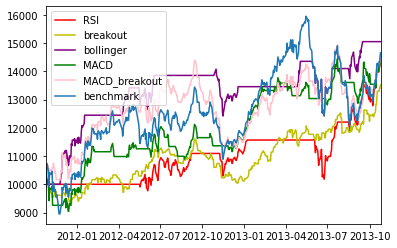

In [28]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
plt.xlim(start,end)
plt.legend()
plt.show()

In [10]:
df

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology
...,...,...,...
500,XYL,Xylem Inc.,Industrials
501,YUM,Yum! Brands Inc,Consumer Discretionary
502,ZBH,Zimmer Biomet Holdings,Health Care
503,ZION,Zions Bancorp,Financials


In [11]:
((result_macd['MACD'][-1]/10000)*100)

178.44478858947755

In [12]:
import random
from datetime import date, timedelta
df = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2012, 1, 1), date(2021, 1, 1)


# records cumulative profit results of the strategies and benchmark
cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

# records cumulative profit when the price went down from the beginning.
cum_benchmark_L = []
cum_macd_L = []
cum_rsi_L = []
cum_bollinger_L = []
cum_breakout_L = []
cum_macd_breakout_L =[]

# records cumulative profit when the price went up from the beginning.
cum_benchmark_W = []
cum_macd_W = []
cum_rsi_W = []
cum_bollinger_W = []
cum_breakout_W = []
cum_macd_breakout_W =[]


for i in range(50):
    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = df['Symbol'][random_number]
    
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 2)
    try:
        print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
        price = pdr.get_data_yahoo(symbol, start, end)
        result_macd= macd_strategy(symbol, start, end)
        result_rsi = rsi_strategy(symbol, start, end)
        result_bollinger = bollinger_band_strategy(symbol, start,end)
        result_breakout = breakout_strategy(symbol, start, end,0.5)
        result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)
        cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
        cum_macd.append((result_macd['MACD'][-1]/10000)*100)
        cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
        cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
        cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
        cum_macd_breakout.append((result['MACD'][-1]/10000)*100)

        if (result_rsi['Close'][-1]/result_rsi['Close'][0])>1:
            cum_benchmark_W.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_W.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_W.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_W.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_W.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_W.append((result['MACD'][-1]/10000)*100)
        else: 
            cum_benchmark_L.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_L.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_L.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_L.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_L.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_L.append((result['MACD'][-1]/10000)*100)
    except:
        print("data not existing")
cumulative = (sum(cum_benchmark)/len(cum_benchmark),sum(cum_macd)/len(cum_macd),sum(cum_rsi)/len(cum_rsi),sum(cum_bollinger)/len(cum_bollinger),sum(cum_breakout)/len(cum_breakout),sum(cum_macd_breakout)/len(cum_macd_breakout))
cumulative_W = (sum(cum_benchmark_W)/len(cum_benchmark_W),sum(cum_macd_W)/len(cum_macd_W),sum(cum_rsi_W)/len(cum_rsi_W),sum(cum_bollinger_W)/len(cum_bollinger_W),sum(cum_breakout_W)/len(cum_breakout_W),sum(cum_macd_breakout_W)/len(cum_macd_breakout_W))
cumulative_L = (sum(cum_benchmark_L)/len(cum_benchmark_L),sum(cum_macd_L)/len(cum_macd_L),sum(cum_rsi_L)/len(cum_rsi_L),sum(cum_bollinger_L)/len(cum_bollinger_L),sum(cum_breakout_L)/len(cum_breakout_L),sum(cum_macd_breakout_L)/len(cum_macd_breakout_L))
print(cumulative_W)

Testing in date range : 2018-12-17 2019-12-17for CDNS


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2337481255.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


win rate: 0.3
strategy maximum drawdown -0.19784304821626483
benchmarck maximum drawdwon -17.56
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2014-02-12 2015-02-12for EMR
win rate: 0.15384615384615385
strategy maximum drawdown -0.17613774203453544
benchmarck maximum drawdwon -19.09
strategy maximum drawdown -0.14495333867085702


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-02-21 2016-02-21for ANSS
win rate: 0.2
strategy maximum drawdown -0.24163335108744627
benchmarck maximum drawdwon -16.21
strategy maximum drawdown -0.16116419661653314


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-07-27 2018-07-27for FOX
data not existing
Testing in date range : 2016-02-24 2017-02-24for ADP
win rate: 0.4444444444444444
strategy maximum drawdown -0.08403999200142485
benchmarck maximum drawdwon -10.06
strategy maximum drawdown -0.03750843888270016


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2016-09-12 2017-09-12for ANTM
data not existing
Testing in date range : 2013-03-31 2014-03-31for FCX
win rate: 0.7142857142857143
strategy maximum drawdown -0.1329039367675781
benchmarck maximum drawdwon -20.56
strategy maximum drawdown -0.18425847936752235


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2016-02-10 2017-02-10for SHW
win rate: 0.36363636363636365
strategy maximum drawdown -0.1772115231428001
benchmarck maximum drawdwon -22.9
strategy maximum drawdown -0.14927460897132


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-02-23 2021-02-23for CL
win rate: 0.7777777777777778
strategy maximum drawdown -0.05840371345193931
benchmarck maximum drawdwon -20.54
strategy maximum drawdown -0.0372


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-02-07 2019-02-07for MTB
win rate: 0.18181818181818182
strategy maximum drawdown -0.18136796302833652
benchmarck maximum drawdwon -31.03
strategy maximum drawdown -0.27311159619292524


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-04-14 2018-04-14for JPM
win rate: 0.6
strategy maximum drawdown -0.08485294887585784
benchmarck maximum drawdwon -9.9
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-07-03 2021-07-03for PDCO
win rate: 0.23076923076923078
strategy maximum drawdown -0.3166674782035733
benchmarck maximum drawdwon -23.67
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-07-27 2021-07-27for AES
win rate: 0.4
strategy maximum drawdown -0.14161312542816898
benchmarck maximum drawdwon -18.44
strategy maximum drawdown -0.11094314140452477


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-03-08 2019-03-08for CMS
win rate: 0.7
strategy maximum drawdown -0.06008156415200788
benchmarck maximum drawdwon -9.78
strategy maximum drawdown -0.026985579346761237


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-05-08 2018-05-08for BHGE
data not existing
(126.9599317428733, 108.110917181015, 105.18830882644652, 111.42146306228639, 95.9983505971908, 110.02213462162017)


<BarContainer object of 6 artists>

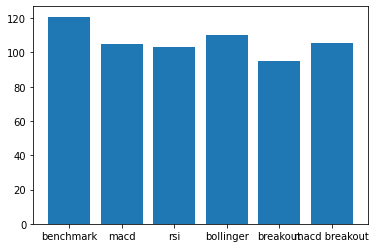

In [13]:
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative)

In [194]:
import random
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
symbol = df['Symbol'][random_number]

from datetime import date, timedelta

# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2020, 10, 1)
  

# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 2)
# printing dates 
print("The testing range : " + str(start) + " " + str(end))





def bullish_bearish(arr, price, k):

	""" Finds bullish and bearish periods with O(n) complexity
	Parameters:
	arr (arr): An array of daily price changes in percentage. (today's closing price - yesterday's closing price)
	price (dataframe): pandas dataframe that include closing price of a stock
	k (int): length of a period in days. If k=30, then we find bullish period that's a month long

	Returns:
	bullsih (arr): A list of index where the next 30 days price change meets the bullish market conditions
	bearish (arr): A list of index where the next 30 days price change meets the bearish market conditions
	"""
	# length of the array
	n = len(arr)

	# n must be greater than k
	if n < k:
		print("Invalid")
		return -1

	# Compute sum of first window of size k
	window_sum = sum(arr[:k])

	# first sum available 
	max_sum = window_sum
	bullish = []
	bearish = []
	# Compute the sums of remaining windows by
	# removing first element of previous
	# window and adding last element of
	# the current window.
	for i in range(n - k):
		window_sum = window_sum - arr[i] + arr[i + k]
		count = sum(map(lambda x : x>0, arr[i:i+k]))

		# if more than 2/3 of the days in the period were positive and the end of the period incrased by more than 10% of the start of the period
		if count>2*k/3 and (price[i+k]-price[i])/price[i]>0.1:
			bullish.append(i)

		# if more than 2/3 of the days in the period were negative and the end of the period decreased by more than 10% of the start of the period
		if count <k/3 and price[i+k]/price[i]<0.9:
			bearish.append(i)
		max_sum = max(window_sum, max_sum)
	return bullish, bearish


price = pdr.get_data_yahoo(symbol, start, end)
price_change = []
for i in range(1, len(price)):
	price_change.append(((price['Close'][i]-price['Close'][i-1])/price['Close'][i-1])*100)
k=30
bullish_periods = (bullish_bearish(price_change,price['Close'][1:], k))[0]
bearish_periods = (bullish_bearish(price_change,price['Close'][1:], k))[1]
print(bearish_periods)

start_index = [bullish_periods[0]]
end_index = []
for i in range(1,len(bullish_periods)-1):
    if start_index[-1]+k<bullish_periods[i]:
        end_index.append(start_index[-1]+k)
        start_index.append(bullish_periods[i])

end_index.append(start_index[-1]+k)
print(start_index, end_index) 


The testing range : 2018-05-01 2020-05-01
[134, 135, 454]
[53, 201, 356, 398] [83, 231, 386, 428]


In [203]:
price[53:83].index[0]

Timestamp('2016-03-18 00:00:00')

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.025163808661231513
benchmarck maximum drawdwon -2.52
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


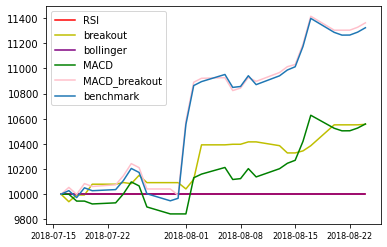

strategy maximum drawdown -0.04241775203202645
benchmarck maximum drawdwon -4.25
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


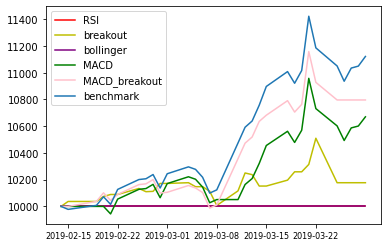

strategy maximum drawdown -0.02498452207338042
benchmarck maximum drawdwon -2.51
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


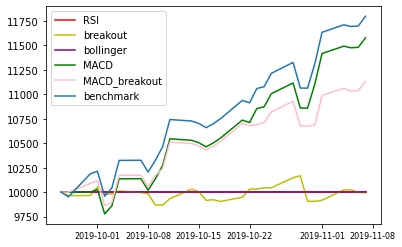

strategy maximum drawdown -0.02744664306640625
benchmarck maximum drawdwon -3.13
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


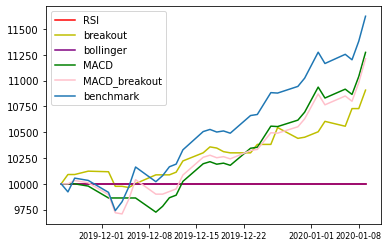

[11322.612724092229, 11121.19400200955, 11798.17151284208, 11624.057159538299] [10558.127456665039, 10669.840454101562, 11577.969619750977, 11273.77075958252] [10000.0, 10000.0, 10000.0, 10000.0] [10000.0, 10000.0, 10000.0, 10000.0] [10555.306267547607, 10177.066638183594, 9993.85359191895, 10908.005282592769] [11361.530002593996, 10795.965207290648, 11130.898647689823, 11212.289100646973]


<BarContainer object of 6 artists>

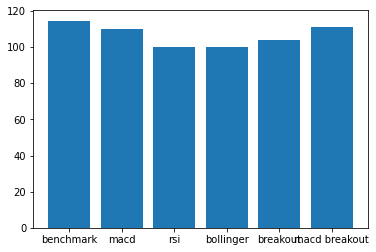

In [195]:
# records the profit of the strategies in a bullish market
bullish_macd = []
bullish_benchmark = []
bullish_rsi = []
bullish_bollinger = []
bullish_breakout = []
bullish_macd_breakout = []

for i in range(len(start_index)):
    new_start = price[start_index[i]:end_index[i]].index[0]
    new_end = price[start_index[i]:end_index[i]].index[-1]

    result_macd= macd_strategy(symbol, new_start, new_end)
    result_rsi = rsi_strategy(symbol, new_start, new_end)
    result_bollinger = bollinger_band_strategy(symbol, new_start,new_end)
    result_breakout = breakout_strategy(symbol, new_start, new_end,0.5)
    result = MACD_BREAKOUT_STRATEGY(symbol, new_start, new_end, 0.3)
    bullish_macd.append(result_macd['MACD'][-1])
    bullish_benchmark.append(result_rsi['Close'][-1]*10000/result_rsi['Close'][0])
    bullish_rsi.append(result_rsi['RSI_strategy'][-1])
    bullish_bollinger.append(result_bollinger['Bollinger'][-1])
    bullish_breakout.append(result_breakout['breakout'][-1])
    bullish_macd_breakout.append(result['MACD'][-1])

    plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
    plt.plot(result_breakout['breakout'],c='y', label = "breakout")
    plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
    plt.plot(result_macd['MACD'],c='g', label = 'MACD')
    plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
    plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
    # plt.xlim(new_start,new_end)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()
print(bullish_benchmark, bullish_macd,bullish_rsi, bullish_bollinger,bullish_breakout,bullish_macd_breakout)
cumulative_profit = (sum(bullish_benchmark)/len(bullish_benchmark)/100, sum(bullish_macd)/len(bullish_macd)/100,sum(bullish_rsi)/len(bullish_rsi)/100, sum(bullish_bollinger)/len(bullish_bollinger)/100,sum(bullish_breakout)/(len(bullish_breakout))/100,sum(bullish_macd_breakout)/len(bullish_breakout)/100)
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative_profit)

In [197]:
start_index = [bearish_periods[0]]
end_index = []
for i in range(1,len(bearish_periods)):
    if start_index[-1]+k<bearish_periods[i]:
        end_index.append(start_index[-1]+k)
        start_index.append(bearish_periods[i])

end_index.append(start_index[-1]+k)
print(start_index, end_index) 

[134, 454] [164, 484]


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.07495499420166016
benchmarck maximum drawdwon -25.3
strategy maximum drawdown -0.151091115455793


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


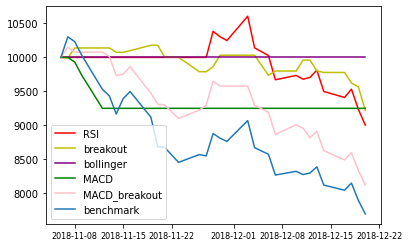

strategy maximum drawdown -0.07236026115417481
benchmarck maximum drawdwon -30.67
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


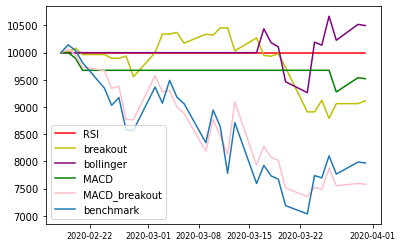

[7696.4223655488195, 7971.473143765919] [9250.450057983398, 9520.384433746338] [9003.277290344238, 10000.0] [10000.0, 10498.299446105957] [9219.49985237122, 9113.047644042972] [8122.943172454836, 7578.582009887697]


<BarContainer object of 6 artists>

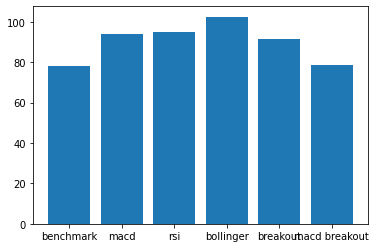

In [198]:
# compares the profits of the strategies in a bearish market
bearish_macd = []
bearish_benchmark = []
bearish_rsi = []
bearish_bollinger = []
bearish_breakout = []
bearish_macd_breakout = []

for i in range(len(start_index)):
    new_start = price[start_index[i]:end_index[i]].index[0]
    new_end = price[start_index[i]:end_index[i]].index[-1]

    result_macd= macd_strategy(symbol, new_start, new_end)
    result_rsi = rsi_strategy(symbol, new_start, new_end)
    result_bollinger = bollinger_band_strategy(symbol, new_start,new_end)
    result_breakout = breakout_strategy(symbol, new_start, new_end,0.5)
    result = MACD_BREAKOUT_STRATEGY(symbol, new_start, new_end, 0.3)
    bearish_macd.append(result_macd['MACD'][-1])
    bearish_benchmark.append(result_rsi['Close'][-1]*10000/result_rsi['Close'][0])
    bearish_rsi.append(result_rsi['RSI_strategy'][-1])
    bearish_bollinger.append(result_bollinger['Bollinger'][-1])
    bearish_breakout.append(result_breakout['breakout'][-1])
    bearish_macd_breakout.append(result['MACD'][-1])
    
    

    plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
    plt.plot(result_breakout['breakout'],c='y', label = "breakout")
    plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
    plt.plot(result_macd['MACD'],c='g', label = 'MACD')
    plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
    plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
    # plt.xlim(new_start,new_end)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()
print(bearish_benchmark, bearish_macd,bearish_rsi, bearish_bollinger,bearish_breakout,bearish_macd_breakout)
cumulative_profit = (sum(bearish_benchmark)/len(bearish_benchmark)/100, sum(bearish_macd)/len(bearish_macd)/100,sum(bearish_rsi)/len(bearish_rsi)/100, sum(bearish_bollinger)/len(bearish_bollinger)/100,sum(bearish_breakout)/(len(bearish_breakout))/100,sum(bearish_macd_breakout)/len(bearish_breakout)/100)
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative_profit)

In [321]:
# calculates the p-value
from scipy import stats
ttest,p_value = stats.ttest_ind(bearish_benchmark,bearish_bollinger)
print("p value:%.8f" % p_value)
print("since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:%.4f" %(p_value/2))
if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.01360149
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:0.0068
Reject null hypothesis


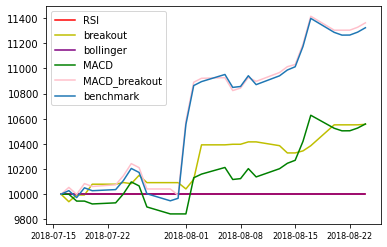

In [184]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
# plt.xlim(new_start,new_end)
plt.legend()
plt.xticks(fontsize=8)
plt.show()

In [46]:
sum(price_change[42:80])

17.62999725341797

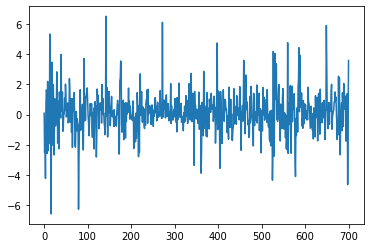

In [117]:
plt.plot(price_change)

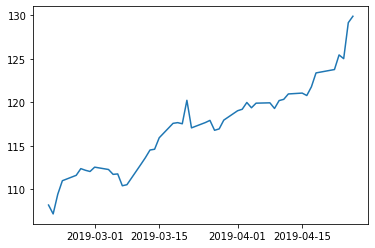

In [68]:
plt.plot(price['Close'][33:81])

In [50]:
price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-31,102.400002,100.440002,101.290001,101.570000,33173800.0,97.580032
2019-01-02,101.750000,98.940002,99.550003,101.120003,35329300.0,97.147705
2019-01-03,100.190002,97.199997,100.099998,97.400002,42579100.0,93.573853
2019-01-04,102.510002,98.930000,99.720001,101.930000,44060600.0,97.925880
2019-01-07,103.269997,100.980003,101.639999,102.059998,35656100.0,98.050766
...,...,...,...,...,...,...
2022-10-06,250.339996,246.080002,247.929993,246.789993,20239900.0,246.789993
2022-10-07,241.320007,233.169998,240.899994,234.240005,37732400.0,234.240005
2022-10-10,234.559998,226.729996,233.050003,229.250000,29743600.0,229.250000


In [ ]:
pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 6.3 MB/s eta 0:00:0000:01
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.7/336.7 kB 10.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import feedparser
from bs4 import BeautifulSoup
import urllib
from dateparser import parse as parse_date
import requests



class GoogleNews:
    def __init__(self, lang = 'en', country = 'US'):
        self.lang = lang.lower()
        self.country = country.upper()
        self.BASE_URL = 'https://news.google.com/rss'

    def __top_news_parser(self, text):
        """Return subarticles from the main and topic feeds"""
        try:
            bs4_html = BeautifulSoup(text, "html.parser")
            # find all li tags
            lis = bs4_html.find_all('li')
            sub_articles = []
            for li in lis:
                try:
                    sub_articles.append({"url": li.a['href'],
                                         "title": li.a.text,
                                         "publisher": li.font.text})
                except:
                    pass
            return sub_articles
        except:
            return text

    def __ceid(self):
        """Compile correct country-lang parameters for Google News RSS URL"""
        return '?ceid={}:{}&hl={}&gl={}'.format(self.country,self.lang,self.lang,self.country)

    def __add_sub_articles(self, entries):
        for i, val in enumerate(entries):
            if 'summary' in entries[i].keys():
                entries[i]['sub_articles'] = self.__top_news_parser(entries[i]['summary'])
            else:
                entries[i]['sub_articles'] = None
        return entries

    def __scaping_bee_request(self, api_key, url):
        response = requests.get(
            url="https://app.scrapingbee.com/api/v1/",
            params={
                "api_key": api_key,
                "url": url,
                "render_js": "false"
            }
        )
        if response.status_code == 200:
            return response
        if response.status_code != 200:
            raise Exception("ScrapingBee status_code: "  + str(response.status_code) + " " + response.text)

    def __parse_feed(self, feed_url, proxies=None, scraping_bee = None):

        if scraping_bee and proxies:
            raise Exception("Pick either ScrapingBee or proxies. Not both!")

        if proxies:
            r = requests.get(feed_url, proxies = proxies)
        else:
            r = requests.get(feed_url)

        if scraping_bee:
            r = self.__scaping_bee_request(url = feed_url, api_key = scraping_bee)
        else:
            r = requests.get(feed_url)


        if 'https://news.google.com/rss/unsupported' in r.url:
            raise Exception('This feed is not available')

        d = feedparser.parse(r.text)

        if not scraping_bee and not proxies and len(d['entries']) == 0:
            d = feedparser.parse(feed_url)

        return dict((k, d[k]) for k in ('feed', 'entries'))

    def __search_helper(self, query):
        return urllib.parse.quote_plus(query)

    def __from_to_helper(self, validate=None):
        try:
            validate = parse_date(validate).strftime('%Y-%m-%d')
            return str(validate)
        except:
            raise Exception('Couldnt parse your date')



    def top_news(self, proxies=None, scraping_bee = None):
        """Return a list of all articles from the main page of Google News
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + self.__ceid(), proxies=proxies, scraping_bee=scraping_bee)
        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def topic_headlines(self, topic: str, proxies=None, scraping_bee=None):
        """Return a list of all articles from the topic page of Google News
        given a country and a language"""
        #topic = topic.upper()
        if topic.upper() in ['WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SCIENCE', 'SPORTS', 'HEALTH']:
            d = self.__parse_feed(self.BASE_URL + '/headlines/section/topic/{}'.format(topic.upper()) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        else:
            d = self.__parse_feed(self.BASE_URL + '/topics/{}'.format(topic) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        if len(d['entries']) > 0:
            return d
        else:
            raise Exception('unsupported topic')

    def geo_headlines(self, geo: str, proxies=None, scraping_bee=None):
        """Return a list of all articles about a specific geolocation
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + '/headlines/section/geo/{}'.format(geo) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def search(self, query: str, helper = True, when = None, from_ = None, to_ = None, proxies=None, scraping_bee=None):
        """
        Return a list of all articles given a full-text search parameter,
        a country and a language

        :param bool helper: When True helps with URL quoting
        :param str when: Sets a time range for the artiles that can be found
        """

        if when:
            query += ' when:' + when

        if from_ and not when:
            #from_ = self.__from_to_helper(validate=from_)
            query += ' after:' + from_

        if to_ and not when:
            #to_ = self.__from_to_helper(validate=to_)
            query += ' before:' + to_

        if helper == True:
            query = self.__search_helper(query)

        search_ceid = self.__ceid()
        search_ceid = search_ceid.replace('?', '&')

        d = self.__parse_feed(self.BASE_URL + '/search?q={}'.format(query) + search_ceid, proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

In [17]:
import pandas as pd
import datetime
gn = GoogleNews()
def get_news(search):
    stories = []
    start_date = datetime.date(2022,9,8)
    end_date = datetime.date(2022,9,24)
    delta = datetime.timedelta(days=1)
    date_list = pd.date_range(start_date, end_date).tolist()
    for date in date_list[:-1]:
        result = gn.search(search, from_=date.strftime('%Y-%m-%d'), to_=(date+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']
        for item in newsitem:
            story = {
                'title':item.title,
            }
            stories.append(story)
    return stories

df = pd.DataFrame(get_news('AAPL'))

In [18]:
df

,title
0,AAPL Stock Will Rise as Consumers Search to Pr...
1,AAPL Stock Alert: 13 Takeaways From the Latest...
2,Why Apple Fell Today - The Motley Fool
3,Apple Introduces iPhone 14 With Satellite Comm...
4,Apple Analyst Sees iPhone 14 Boost From Pent U...
...,...
1077,"Stock Market News for Sep 23, 2022 - Nasdaq"
1078,"Why ExxonMobil, Occidental Petroleum, and Phil..."
1079,The Market Crash Americans Aren't Seeing - Nasdaq
1080,7 Investments for the FatFIRE Movement - Inves...


In [8]:
pip install nltk==3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394471 sha256=e251d0607089f675229b8b9929d876689a1afb796a6674cec63a8bc9e7239083
  Stored in directory: /Users/haechan/Library/Caches/pip/wheels/b5/0e/53/5cfbc5d26eca272bf9e6694836529448e7724765b6ae040d79
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Note: you may need to restart the kernel to use updated packages.


In [10]:
import nltk

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      28 non-null     object
 1   link       28 non-null     object
 2   published  28 non-null     object
dtypes: object(3)
memory usage: 800.0+ bytes


In [65]:
df['title'] = df['title'].astype(str).str.lower()
df.head(3)

,title
0,aapl stock will rise as consumers search to pr...
1,aapl stock alert: 13 takeaways from the latest...
2,why apple fell today - the motley fool


In [20]:
from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')

df['text_token']=df['title'].apply(regexp.tokenize)
df.head(3)

,title,text_token
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,..."
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, s, commercial..."


In [21]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [23]:
# Remove stopwords
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)

,title,text_token
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,..."
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r..."


In [24]:

df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [25]:
df[['title', 'text_token', 'text_string']].head()

,title,text_token,text_string
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,...",southern tire mart pilot flying form strategic...
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r...",purcell tire joins michelin commercial retread...


In [26]:
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'tire': 4, 'modern': 2, 'dealer': 2, 'southern': 1, 'mart': 1, 'pilot': 1, 'flying': 1, 'form': 1, 'strategic': 1, 'alliance': 1, ...})

In [27]:
df['text_string_fdist'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

In [28]:
df[['title', 'text_token', 'text_string', 'text_string_fdist']].head()

,title,text_token,text_string,text_string_fdist
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,...",southern tire mart pilot flying form strategic...,southern tire mart pilot flying form strategic...
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r...",purcell tire joins michelin commercial retread...,purcell tire joins michelin commercial retread...


In [29]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/haechan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/haechan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()

df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)

In [222]:
all_words_lem = ' '.join([word for word in df['text_string_lem']])

In [223]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/haechan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [224]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem)

In [225]:
# sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [227]:
# polarity scores
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)

,title,text_token,text_string,text_string_fdist,text_string_lem,polarity
1150,Why Nio Stock Is Sliding Today - Nasdaq,"[Why, Nio, Stock, Is, Sliding, Today, Nasdaq]",Why Nio Stock Sliding Today Nasdaq,Why Nio Stock Sliding Today Nasdaq,Why Nio Stock Sliding Today Nasdaq,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1151,Daseke Accepts Resignation Of CFO Jason Bates ...,"[Daseke, Accepts, Resignation, Of, CFO, Jason,...",Daseke Accepts Resignation CFO Jason Bates Nasdaq,Daseke Accepts Resignation CFO Jason Bates Nasdaq,Daseke Accepts Resignation CFO Jason Bates Nasdaq,"{'neg': 0.232, 'neu': 0.526, 'pos': 0.242, 'co..."
1152,Why Algonquin Power & Utilities is a Top 10 SA...,"[Why, Algonquin, Power, Utilities, Top, 10, SA...",Why Algonquin Power Utilities Top SAFE Interna...,Why Algonquin Power Utilities Top SAFE Interna...,Why Algonquin Power Utilities Top SAFE Interna...,"{'neg': 0.0, 'neu': 0.624, 'pos': 0.376, 'comp..."


In [228]:
df = pd.concat(
    [df.drop(['polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)

In [229]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df['compound'].mean()<0
df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']

True

In [270]:
random_number = random.randint(1,500)
df = pd.read_csv('constituents_csv.csv')
symbol = df['Symbol'][random_number]
    # getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
start.year

2016

In [274]:
df = pd.read_csv('constituents_csv.csv')
df['Symbol']

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
500     XYL
501     YUM
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 505, dtype: object

In [280]:
import random
from datetime import date, timedelta
symbols = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2012, 1, 1), date(2021, 1, 1)

cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

cum_benchmark_EN = []
cum_macd_EN = []
cum_rsi_EN = []
cum_bollinger_EN = []
cum_breakout_EN = []
cum_macd_breakout_EN =[]

cum_benchmark_N = []
cum_macd_N = []
cum_rsi_N = []
cum_bollinger_N = []
cum_breakout_N = []
cum_macd_breakout_N =[]

cum_benchmark_P = []
cum_macd_P = []
cum_rsi_P = []
cum_bollinger_P = []
cum_breakout_P = []
cum_macd_breakout_P =[]

cum_benchmark_EP = []
cum_macd_EP = []
cum_rsi_EP = []
cum_bollinger_EP = []
cum_breakout_EP = []
cum_macd_breakout_EP=[]


monthly_sentiments=[]

for i in range(1):

    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = symbols['Symbol'][random_number]
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 1)

    for month in range(1,5):
        start = datetime.datetime(start.year, month, 1)
        end= datetime.datetime(start.year,month+1, 1)
        price = pdr.get_data_yahoo('AAPL', start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=1)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(len(price)):
            #scraping google news titles
            stories = []
            result = gn.search('AAPL', from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                        
                }
                stories.append(story)


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

        try:
            print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
            price = pdr.get_data_yahoo(symbol, start, end)
            result_macd= macd_strategy(symbol, start, end)
            result_rsi = rsi_strategy(symbol, start, end)
            result_bollinger = bollinger_band_strategy(symbol, start,end)
            result_breakout = breakout_strategy(symbol, start, end,0.5)
            result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)

            # when the sentiment is extremely negative
            if monthly_sentiments[-1] < 0.01:
                cum_benchmark_EN.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EN.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EN.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EN.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EN.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EN.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is negative
            elif 0.01<=monthly_sentiments[-1] < 0.05:
                cum_benchmark_N.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_N.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_N.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_N.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_N.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_N.append((result['MACD'][-1]/10000)*100)

            # when the sentiment is neutral
            elif 0.05<=monthly_sentiments[-1] < 0.09:
                cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is positive
            elif 0.09<=monthly_sentiments[-1] < 0.13:
                cum_benchmark_P.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_P.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_P.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_P.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_P.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_P.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is extremely positive
            else: 
                cum_benchmark_EP.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EP.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EP.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EP.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EP.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EP.append((result['MACD'][-1]/10000)*100)
        except:
            print("data not existing")
#cumulative_P = (sum(cum_benchmark_P)/len(cum_benchmark_P),sum(cum_macd_P)/len(cum_macd_P),sum(cum_rsi_P)/len(cum_rsi_P),sum(cum_bollinger_P)/len(cum_bollinger_P),sum(cum_breakout_P)/len(cum_breakout_P),sum(cum_macd_breakout_P)/len(cum_macd_breakout_P))

#print(cumulative_P)

Testing in date range : 2013-01-01 00:00:00 2013-02-01 00:00:00for AMP


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.029835121319082735
benchmarck maximum drawdwon -2.99
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-02-01 00:00:00 2013-03-01 00:00:00for AMP
strategy maximum drawdown -0.04802360766962952
benchmarck maximum drawdwon -4.04
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-03-01 00:00:00 2013-04-01 00:00:00for AMP
strategy maximum drawdown -0.024389342324918184
benchmarck maximum drawdwon -2.68
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-04-01 00:00:00 2013-05-01 00:00:00for AMP
strategy maximum drawdown -0.07641106719970703
benchmarck maximum drawdwon -7.55
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


ZeroDivisionError: division by zero

In [35]:
# RUN2
import random
from datetime import date, timedelta
symbols = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2019, 1, 1), date(2021, 1, 1)

#neutral
cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

#extremely negative
cum_benchmark_EN = []
cum_macd_EN = []
cum_rsi_EN = []
cum_bollinger_EN = []
cum_breakout_EN = []
cum_macd_breakout_EN =[]

#negative
cum_benchmark_N = []
cum_macd_N = []
cum_rsi_N = []
cum_bollinger_N = []
cum_breakout_N = []
cum_macd_breakout_N =[]

#positive
cum_benchmark_P = []
cum_macd_P = []
cum_rsi_P = []
cum_bollinger_P = []
cum_breakout_P = []
cum_macd_breakout_P =[]

#extemely positive
cum_benchmark_EP = []
cum_macd_EP = []
cum_rsi_EP = []
cum_bollinger_EP = []
cum_breakout_EP = []
cum_macd_breakout_EP=[]


monthly_sentiments=[]

for i in range(1):

    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = symbols['Symbol'][random_number]
    #symbol = 'AAPL'
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 1)
    #data = pdr.get_data_yahoo(symbol, start, end)
    for month in range(1,11):
        start = datetime.datetime(start.year, month, 1)
        end= datetime.datetime(start.year,month+1, 1)
        price = pdr.get_data_yahoo(symbol, start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=7)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(0,len(price),7):
            #scraping google news titles
            stories = []
            result = gn.search(symbol, from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                }
                stories.append(story)      


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

        try:
            print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
            price = pdr.get_data_yahoo(symbol, start, end)
            result_macd= macd_strategy(symbol, start, end)
            result_rsi = rsi_strategy(symbol, start, end)
            result_bollinger = bollinger_band_strategy(symbol, start,end)
            result_breakout = breakout_strategy(symbol, start, end,0.5)
            result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)

            # REVISE!
            if monthly_sentiments[-1] < 0.01:
                #extremley negative
                cum_benchmark_EN.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EN.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EN.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EN.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EN.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EN.append((result['MACD'][-1]/10000)*100)

            elif 0.01<=monthly_sentiments[-1] < 0.05:
                cum_benchmark_N.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_N.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_N.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_N.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_N.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_N.append((result['MACD'][-1]/10000)*100)
            elif 0.05<=monthly_sentiments[-1] < 0.09:
                cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout.append((result['MACD'][-1]/10000)*100)
            elif 0.09<=monthly_sentiments[-1] < 0.13:
                cum_benchmark_P.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_P.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_P.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_P.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_P.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_P.append((result['MACD'][-1]/10000)*100)
            else: 
                cum_benchmark_EP.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EP.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EP.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EP.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EP.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EP.append((result['MACD'][-1]/10000)*100)
        except:
            print("data not existing")
#cumulative_P = (sum(cum_benchmark_P)/len(cum_benchmark_P),sum(cum_macd_P)/len(cum_macd_P),sum(cum_rsi_P)/len(cum_rsi_P),sum(cum_bollinger_P)/len(cum_bollinger_P),sum(cum_breakout_P)/len(cum_breakout_P),sum(cum_macd_breakout_P)/len(cum_macd_breakout_P))

#print(cumulative_P)

                                               title  \
0  armed offenders squads tactics 'flipped' to co...   

                                          text_token  \
0  [armed, offenders, squads, tactics, flipped, c...   

                                         text_string  \
0  armed offenders squads tactics flipped counter...   

                                     text_string_lem    neg    neu  pos  \
0  armed offenders squads tactics flipped counter...  0.591  0.409  0.0   

   compound sentiment  
0   -0.8779  negative  
                                               title  \
0  aos in western bay following tauranga assault ...   

                                          text_token  \
0  [aos, western, bay, following, tauranga, assau...   

                                         text_string  \
0  aos western bay following tauranga assault bay...   

                                     text_string_lem    neg    neu  pos  \
0  aos western bay following tauranga assault ba

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.04815004768371582
benchmarck maximum drawdwon -12.05
data not existing
                                               title  \
0  new hibiki-class surtass / ocean surveillance ...   
1  my internship at john hopkins university appli...   
2  national technical honor society / about - lou...   

                                          text_token  \
0  [new, hibiki, class, surtass, ocean, surveilla...   
1  [internship, john, hopkins, university, applie...   
2  [national, technical, honor, society, loudoun,...   

                                         text_string  \
0  new hibiki class surtass ocean surveillance sh...   
1  internship john hopkins university applied phy...   
2  national technical honor society loudoun count...   

                                     text_string_lem  neg    neu    pos  \
0  new hibiki class surtass ocean surveillance sh...  0.0  0.870  0.130   
1  internship john hopkins university applied phy...  0.0  1.000  0.000   


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.08677792739868163
benchmarck maximum drawdwon -11.16
data not existing


KeyboardInterrupt: 

In [299]:
monthly_sentiments

[]

In [300]:
cumulative_EN = (sum(cum_benchmark_EN)/len(cum_benchmark_EN),sum(cum_macd_EN)/len(cum_macd_EN),sum(cum_rsi_EN)/len(cum_rsi_EN),sum(cum_bollinger_EN)/len(cum_bollinger_EN),sum(cum_breakout_EN)/len(cum_breakout_EN),sum(cum_macd_breakout_EN)/len(cum_macd_breakout_EN))
cumulative_EN

ZeroDivisionError: division by zero

In [307]:
#hypothesis testing example
from scipy import stats
sync = np.array([94. , 84.9, 82.6, 69.5, 80.1, 79.6, 81.4, 77.8, 81.7, 78.8, 73.2,
       87.9, 87.9, 93.5, 82.3, 79.3, 78.3, 71.6, 88.6, 74.6, 74.1, 80.6])
asyncr = np.array([77.1, 71.7, 91. , 72.2, 74.8, 85.1, 67.6, 69.9, 75.3, 71.7, 65.7, 72.6, 71.5, 78.2])
ttest,p_value = stats.ttest_ind(sync,asyncr)
print("p value:%.8f" % p_value)
print("since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:%.4f" %(p_value/2))
if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.00753598
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:0.0038
Reject null hypothesis


In [33]:
# RUN1 get the thresholds for the sentiments
import random
stocks = []
df = pd.read_csv('constituents_csv.csv')
for i in range(10):
    #randomly selects 10 stock symbols
    random_number = random.randint(1,500)
    symbol = df['Symbol'][random_number]
    stocks.append(symbol)

monthly_sentiments=[]
for i in range(len(stocks)):
    for month in range(1,12):
        start = datetime.datetime(2021, month, 1)
        end= datetime.datetime(2021,month+1, 1)
        price = pdr.get_data_yahoo(stocks[i], start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=1)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(len(price)):
            #scraping google news titles
            stories = []
            result = gn.search(symbol, from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                        
                }
                stories.append(story)


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

                                               title  \
0  cxloyalty group holdings inc. completes sale o...   

                                          text_token  \
0  [cxloyalty, group, holdings, inc, completes, s...   

                                         text_string  \
0  cxloyalty group holdings inc completes sale gl...   

                                     text_string_lem  neg    neu    pos  \
0  cxloyalty group holdings inc completes sale gl...  0.0  0.759  0.241   

   compound sentiment  
0    0.5423  positive  
                                               title  \
0  haven, the amazon-berkshire-jpmorgan venture t...   
1  how four of this year's transformers helped th...   
2  billionaire daniel sundheim’s top 10 stock pic...   

                                          text_token  \
0  [amazon, berkshire, jpmorgan, venture, disrupt...   
1  [four, year, transformers, helped, world, bigg...   
2  [billionaire, daniel, sundheim, top, 10, stock...   

            

KeyboardInterrupt: 

In [267]:
monthly_sentiments.sort()
monthly_sentiments

[0.012621321601104211,
 0.014979848484848492,
 0.014979848484848492,
 0.022677709750566884,
 0.022677709750566884,
 0.04319994694918609,
 0.04935780867683043,
 0.05525553571428572,
 0.05525553571428572,
 0.05684538175208631,
 0.05764650621118013,
 0.06710377016922474,
 0.06870502070393375,
 0.07265060041407868,
 0.09656661796536797,
 0.10295559523809526,
 0.10340195652173914,
 0.10586021739130436,
 0.10677750000000003,
 0.10732365079365082,
 0.10926954545454547,
 0.12007798160173162]

In [233]:
def sentiment_strategy(symbol, start, end):
    """
    the function conducts backtesting for a trading strategy based on sentiment analysis. 
    input: 
        symbol: str. Stock name
        start: datetime. 
        end: datetime 
    output:
        a dataframe with backtest result of the strategy and sentiments of each day
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    sentiment = False
    sentiments = [sentiment]
    
    #scrape
    gn = GoogleNews()
    
    delta = datetime.timedelta(days=1)
    #date_list = pd.date_range(start, end).tolist()
    date_list = price.index
        
    for i in range(len(price)-1):

        #scraping google news titles
        stories = []
        result = gn.search(symbol, from_=date_list[i].strftime('%Y-%m-%d'), to_=(date_list[i]+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']

        for item in newsitem:
            story = {
                'title':item.title,
                    
            }
            stories.append(story)


        df = pd.DataFrame(stories)


        if df.empty:
            asset.append(money + (price['Close'][i]*numb))
            sentiments.append(sentiment)
        else:
            #NLP
            df['title'] = df['title'].astype(str).str.lower()
            regexp = RegexpTokenizer('\w+')
            df['text_token']=df['title'].apply(regexp.tokenize)

            #remove stop words
            stopwords = nltk.corpus.stopwords.words("english")
            df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
            #remove words shorter than 2 letters
            df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
            wordnet_lem = WordNetLemmatizer()

            df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
            all_words_lem = ' '.join([word for word in df['text_string_lem']])
            words = nltk.word_tokenize(all_words_lem)
            analyzer = SentimentIntensityAnalyzer()
            df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
            df = pd.concat(
            [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
            df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
            sentiment_compound = df['compound'].mean()
            # sentiment_numbers= df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']
            if sentiment_compound > 0:
                if numb==0:
                    buy = price['Close'][i]
                    numb = money//buy
                    money-=numb*buy
                    sentiment = True
                    sentiments.append(sentiment)
                else:
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    sentiments.append(sentiment)
                    continue
            else:
                if numb!=0 : 
                    sell = price['Close'][i]
                    money += (sell)*numb
                    exchange +=1
                    if sell>buy:
                        wins +=1
                    difference.append(sell-buy)
                    numb=0
                    sentiment = False
                    sentiments.append(sentiment)
                else: 
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    continue
            
            asset.append(money + (price['Close'][i]*numb))
            sentiments.append(sentiment)
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['sentiment_analysis']= sentiments
    price['sentiment']=asset
    # price['DD']=drawdowns

    # STARTING_BALANCE = 10000
    # #daily return
    # price['Return'] = price.Close / price.Close.shift(1)
    # price.Return.iat[0] = 1
    # price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    # #calculate drawdown
    # price['Bench_Peak'] = price.Bench_Bal.cummax()
    # price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    # bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    # print("win rate:", wins/exchange)
    # print("strategy maximum drawdown", min(price['DD']))
    # print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [234]:
start = datetime.datetime(2022, 6, 14)
end= datetime.datetime(2022,6, 28)
symbol = 'AAPL'
sentiment_result = sentiment_strategy(symbol, start, end)
# date_list = pd.date_range(start, end).tolist()
# (date_list)
sentiment_result

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/1406036681.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


                                                title  \
0   why aapl stock could still go lower - investor...   
1   faang can fight the fed, fundstrat says (nasda...   
2   jpmorgan sees big jump in apple gaming, music ...   
3   apple is starting to walk and talk like a bank...   
4   developers conferences exhibit aapl & msft str...   
5   mario gabelli’s 2022 portfolio: 10 tech stock ...   
6   7 stocks to buy before the s&p 500 hits 5000 -...   
7   original apple-1 computer signed by steve wozn...   
8   here's how much $1000 invested in halliburton ...   
9   as electric vehicle cos. get run off the road,...   
10  4 reasons to keep investing through this stock...   
11  bwxt medical, triumf agree to manufacture high...   
12  ipg health launches humancare, new full-servic...   
13  crypto hacks on social media platforms have in...   
14  dow jones dives 600 points as treasury yields ...   
15  new york abortion laws shield patients and pro...   
16  lightning versus usb-c: pro

ValueError: Length of values (12) does not match length of index (11)

In [ ]:
sentiment_result['sentiment_analysis'][0]

False

In [4]:
def macd_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()


    #sentiment analysis
    sentiment = sentiment_strategy(symbol, start, end)

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    
    for i in range(len(price)-1):
        if price['Long'][i] == True and sentiment[i]==True:
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
           
            if numb!=0: 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    